## University Ranking Predictions

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
shanghai_data_full = pd.read_csv("data/shanghaiData.csv")
shanghai_data_full = shanghai_data_full[shanghai_data_full.total_score.notnull()]
shanghai_data_full.head()

,world_rank,university_name,national_rank,total_score,alumni,award,hici,ns,pub,pcp,year
0,1,Harvard University,1,100.0,100.0,100.0,100.0,100.0,100.0,72.4,2005
1,2,University of Cambridge,1,73.6,99.8,93.4,53.3,56.6,70.9,66.9,2005
2,3,Stanford University,2,73.4,41.1,72.2,88.5,70.9,72.3,65.0,2005
3,4,"University of California, Berkeley",3,72.8,71.8,76.0,69.4,73.9,72.2,52.7,2005
4,5,Massachusetts Institute of Technology (MIT),4,70.1,74.0,80.6,66.7,65.8,64.3,53.0,2005


## Split to Training and Test

In [2]:
names_full = shanghai_data_full['university_name'][0:100]
rows = np.random.choice(names_full.index.values, 20)
names_test = names_full.ix[rows]
names = names_full.drop(rows)

In [3]:
shanghai_data_test = shanghai_data_full[shanghai_data_full.university_name.isin(names_test)]
shanghai_data = shanghai_data_full[shanghai_data_full.university_name.isin(names)]

features_with_name = ['total_score', 'university_name', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'pub', 'pcp', 'year']
prediction_data_test = shanghai_data_test.loc[:,features_with_name]
prediction_data = shanghai_data.loc[:,features_with_name]

## Scaling Features

In [4]:
from sklearn.preprocessing import StandardScaler

to_predict = ['total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp']
scaler = StandardScaler()
scaler.fit(prediction_data.loc[:,to_predict])
prediction_data.loc[:,to_predict] = scaler.transform(prediction_data.loc[:,to_predict])
prediction_data_test.loc[:,to_predict] = scaler.transform(prediction_data_test.loc[:,to_predict])
prediction_data.head()

,total_score,university_name,national_rank,alumni,award,hici,ns,pub,pcp,year
0,4.380174,Harvard University,-0.931261,3.837768,3.225430,3.873876,4.141286,3.473802,2.959820,2005
1,2.523237,University of Cambridge,-0.931261,3.827299,2.931717,0.985215,1.406407,1.229828,2.555636,2005
2,2.509169,Stanford University,-0.867639,0.754698,1.988275,3.162536,2.307530,1.337786,2.416009,2005
3,2.466966,"University of California, Berkeley",-0.804018,2.361663,2.157383,1.981091,2.496577,1.330075,1.512107,2005
4,2.277052,Massachusetts Institute of Technology (MIT),-0.740396,2.476820,2.362092,1.814081,1.986151,0.720886,1.534153,2005


## Using Multiple Past Years

In [5]:
years_back = 4
to_predict = ['total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp', 'year']
for index, row in prediction_data.iterrows():
    is_complete = True
    current_row = prediction_data[(prediction_data.university_name == row.university_name) & (prediction_data.year == row.year)]
    past_rows = {}
    for year in range(1, years_back+1):
        past_row = prediction_data[(prediction_data.university_name == row.university_name) & (prediction_data.year == row.year-year)]
        past_rows[year] = past_row
        if len(past_row.values) == 0:
            is_complete = False
    
    if (is_complete):
        prediction_data.loc[index, 'score_relative'] = (float(current_row['total_score'].values[0]) - float(past_row['total_score'].values[0]))
        
        for year in range(1, years_back+1):
            past_row = past_rows[year]
            for feature in to_predict:
                prediction_data.loc[index, feature + '_back_' + str(year)] = float(past_row[feature].values[0])

complete_filter = prediction_data.apply(lambda row : np.isnan(row['total_score_back_' + str(years_back)]),axis=1) 
prediction_data_clean = prediction_data[~complete_filter]
prediction_data_clean.head()

,total_score,university_name,national_rank,alumni,award,hici,ns,pub,pcp,year,...,year_back_3,total_score_back_4,national_rank_back_4,alumni_back_4,award_back_4,hici_back_4,ns_back_4,pub_back_4,pcp_back_4,year_back_4
2013,4.380174,Harvard University,-0.931261,3.837768,3.225430,3.873876,4.141286,3.473802,3.136191,2009,...,2006.0,4.380174,-0.931261,3.837768,3.225430,3.873876,4.141286,3.473802,2.959820,2005.0
2014,2.488067,Stanford University,-0.867639,0.644775,2.277538,3.075938,2.080674,1.168138,2.555636,2009,...,2006.0,2.509169,-0.867639,0.754698,1.988275,3.162536,2.307530,1.337786,2.416009,2005.0
2015,2.340356,"University of California, Berkeley",-0.804018,2.131349,2.206335,1.919236,2.320134,1.083315,1.548851,2009,...,2006.0,2.466966,-0.804018,2.361663,2.157383,1.981091,2.496577,1.330075,1.512107,2005.0
2016,2.284086,University of Cambridge,-0.931261,3.282920,2.847163,1.016142,1.236265,0.805710,2.452753,2009,...,2006.0,2.523237,-0.931261,3.827299,2.931717,0.985215,1.406407,1.229828,2.555636,2005.0
2017,2.234849,Massachusetts Institute of Technology (MIT),-0.740396,2.319788,2.362092,1.752225,2.118484,0.543527,1.637036,2009,...,2006.0,2.277052,-0.740396,2.476820,2.362092,1.814081,1.986151,0.720886,1.534153,2005.0


## Dont Modify `prediction_data_clean` From Here 

In [89]:
features = []
for feature in to_predict:
    for year in range(1, years_back+1):
        features.append(feature + '_back_' + str(year))

In [ ]:
X = prediction_data_clean.loc[:,features]

# Test faster
num_examples_to_use = 200 # max 479
X = X[0:num_examples_to_use]

In [ ]:
from sklearn.cross_validation import cross_val_score

from sklearn.linear_model import LinearRegression
def get_classifier_linear_regression(X, y):
    clf = LinearRegression()
    param_grid = {
        'normalize': [0.00000001, 0.0000001, 0.000001, 0.00001]
    }
    clf = GridSearchCV(clf, param_grid, cv=10)
    clf.fit(X, y)
    print (clf.best_params_)
    return clf

from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
def get_classifier_svm(X, y):
    clf = SVR()
    param_grid = [
        {'C': [0.1, 1, 10], 'kernel': ['linear']},
        {'C': [100, 1000, 10000], 'gamma': [0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
    ]
    clf = GridSearchCV(clf, param_grid, cv=10)
    clf.fit(X, y)
    print (clf.best_params_)
    return clf

from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
def get_classifier_rbm(X, y):
    linear = LinearRegression()
    rbm = BernoulliRBM(random_state=0)
    clf = Pipeline(steps=[('rbm', rbm), ('linear', linear)])
    param_grid = {
        'rbm__n_iter':[30],
        'rbm__n_components':[300],
        'rbm__learning_rate':[0.00001, 0.0001, 0.001, 0.01], 
        'linear__normalize':[0.00001],
    }
    
    clf = GridSearchCV(clf, param_grid, cv=10)
    clf.fit(X, y)
    
    #rbm.n_iter = 20
    #rbm.n_components = 100
    print (clf.best_params_)
    return clf

from sknn.mlp import Regressor, Layer
def get_classifier_sknn_regressor(X, y):
    clf = Regressor(
        layers=[
            Layer("Rectifier", units=100),
            Layer("Rectifier", units=100),
            Layer("Linear")],
        learning_rate=0.02,
        n_iter=10)
    clf.fit(X, y)
    return clf

clf_map = {}
# Can we score ourself with a few iterations down the line?
to_predict_with_score = ['score_relative', 'total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp', 'year']
for feature in to_predict_with_score:
    y = np.ravel(prediction_data_clean.loc[:,[feature]])
    # Test faster
    y = y[0:num_examples_to_use]
    
    clf = get_classifier_rbm(X, y)
    
    clf_map[feature] = clf
    cv_scores = cross_val_score(clf, X, y, cv=4)
    print ((1 - cv_scores) * 100) # Error by 100

## Make Prediction Code Reuseable

In [87]:
import seaborn as sb
import matplotlib.pyplot as plt

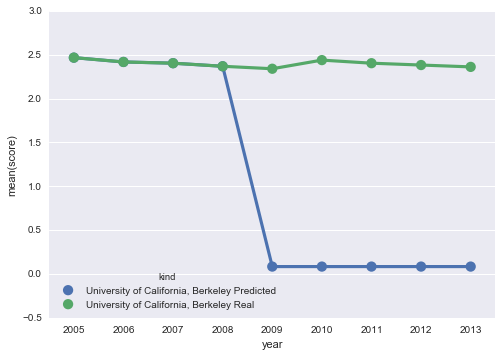

In [88]:
def get_school_graph_data(school_name_to_predict):
    university_data = prediction_data_clean[(prediction_data_clean.university_name == school_name_to_predict) & (prediction_data_clean.year == (2005 + years_back))]
    X = university_data.loc[:,features]
    start_scores = X['total_score_back_' + str(years_back)].values
    for i in range(1, years_back):
        start_scores = np.append(start_scores, X['total_score_back_' + str(years_back-i)].values)

    real_scores = prediction_data_clean[prediction_data_clean.university_name == school_name_to_predict]['total_score'].values
    real_scores = np.append(start_scores, real_scores)
    
    predicted_scores = start_scores.copy()
    X_continue = X.copy()
    for iteration in range(len(real_scores) - years_back):
        X_original = X_continue.copy()
        
        for feature in to_predict:
            X_continue[feature + '_back_1'] = clf_map[feature].predict(X_original)
            for i in range(1, years_back):
                X_continue[feature + '_back_' + str(i + 1)] = X_original[feature + '_back_' + str(i)]
        
        score_relative = clf_map['score_relative'].predict(X_original)
        # Swap out this line for the next
        #X_continue['total_score_back_1'] = X_original['total_score_back_1'] + score_relative
        X_continue['total_score_back_1'] = clf_map['total_score'].predict(X_original)
        
        predicted_scores = np.append(predicted_scores, X_continue['total_score_back_1'].values)
        for i in range(1, years_back):
            X_continue['total_score_back_' + str(i + 1)] = X_original['total_score_back_' + str(i)]
            
    end_year = 2005 + len(real_scores)
    years = np.array(range(2005, end_year))
    predicted = pd.DataFrame({ 'score' : predicted_scores, 'year' : years })
    real = pd.DataFrame({ 'score' : real_scores, 'year' : years })
    predicted['kind'] = school_name_to_predict + ' Predicted'
    real['kind'] = school_name_to_predict + ' Real'
    graph_data = predicted.append(real)
    return graph_data

school_name_to_predict = ['University of California, Berkeley']
graph_data = get_school_graph_data(school_name_to_predict[0])
graph = sb.pointplot(x='year', y='score', hue='kind', data=graph_data)

In [83]:
def plot_scores_by_names(universities_to_plot):
    graph_data = pd.DataFrame()
    num_universitites = len(universities_to_plot)
    linestyles = ["--", "-"]*num_universitites
    markers= ["x", "o"]*num_universitites
    palette = np.repeat(sb.color_palette("Set1", n_colors=num_universitites, desat=.5), 2, axis=0)

    for name in universities_to_plot:
        graph_data = graph_data.append(get_school_graph_data(name))
    fig, (ax) = plt.subplots(1,1, figsize=(20,10))
    sb.pointplot(x='year', y='score', hue='kind', linestyles=linestyles, markers=markers, palette=palette, data=graph_data, ax=ax)

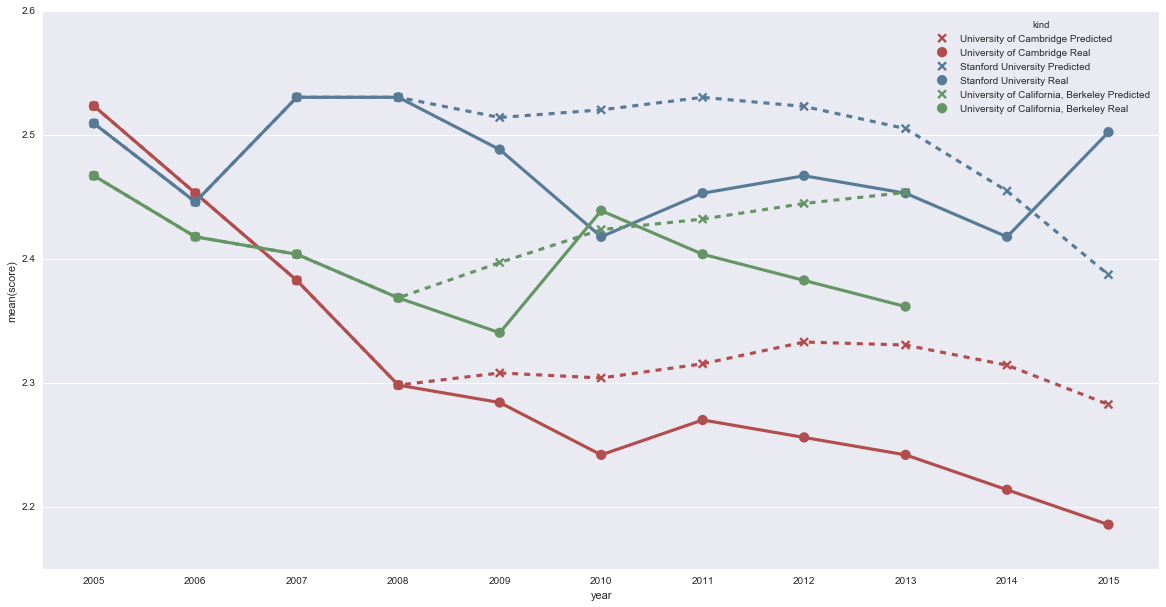

In [84]:
plot_scores_by_names(shanghai_data[1:4]['university_name'].values)

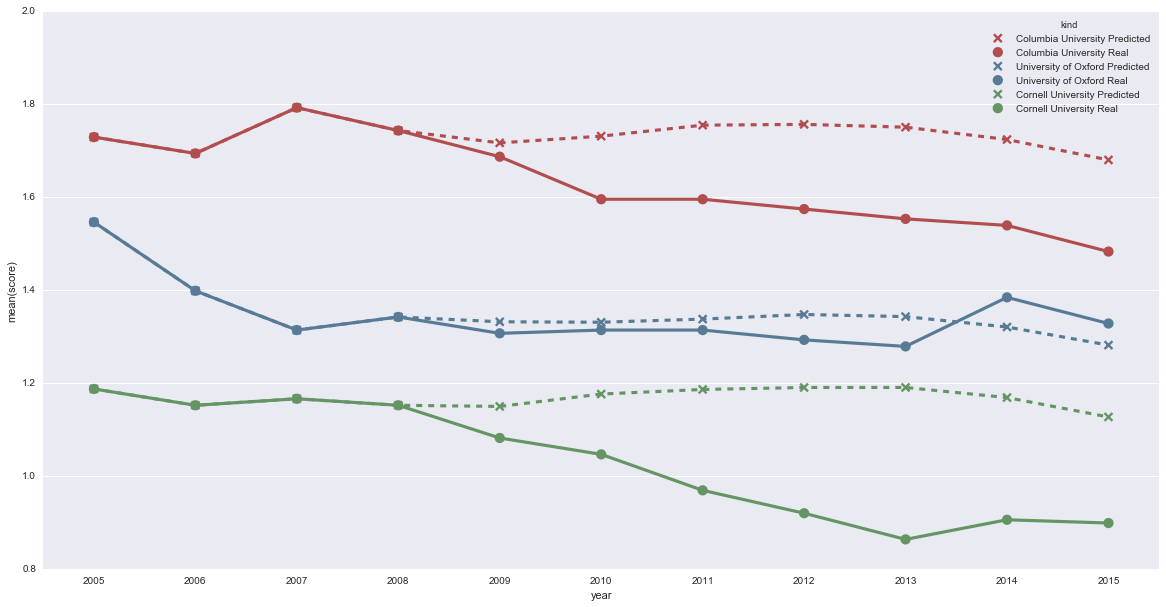

In [78]:
plot_scores_by_names(shanghai_data[6:9]['university_name'].values)

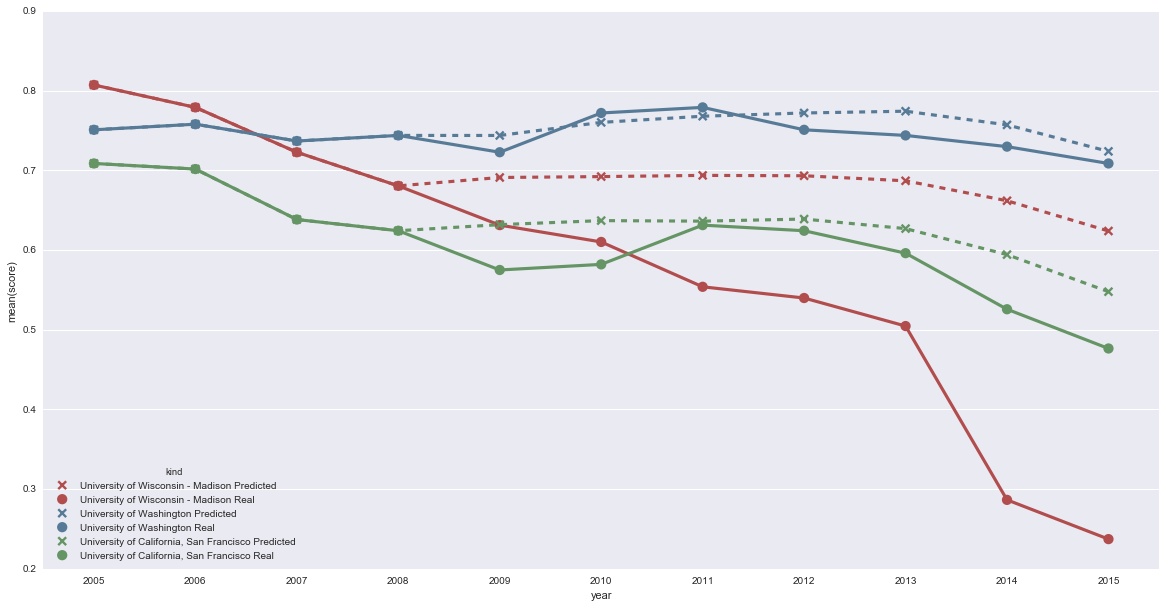

In [79]:
plot_scores_by_names(shanghai_data[11:14]['university_name'].values)